In [808]:
# read in data from excel file to dataframe
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


#===================== Independent Constants =====================
class EnvConstants:
    """Environmental constants for atmospheric and crop conditions with units and descriptions.

    Attributes:
        P (float): Atmospheric pressure (kPa).
        k (float): von Karman's constant (none).
        esurface (float): Emissivity of crop (none).
        sigma (float): Stefan-Boltzmann constant (W m-2 K-4).
        KR (int): Parameter in Equ (24.2) (W m-2).
        KD1 (float): Parameter in Equ (24.6) (kPa-1).
        KD2 (float): Parameter in Equ (24.6) (kPa-2).
        TL (float): Parameter in Equ (24.4) and Equ (24.5) (K).
        T0 (float): Parameter in Equ (24.4) and Equ (24.5) (K).
        TH (float): Parameter in Equ (24.4) and Equ (24.5) (K).
        KM2 (float): Parameter in Equ (24.6) (mm-1).
        rho_a (float): Moist Air density (kg m-3).
        cp (float): Specific heat capacity of air at constant pressure (J kg-1 K-1).
        gc (float): Canopy cover factor (none).
        aT (float): Parameter in temperature stress factor (none).
    """
    P: float = 101.20  # Atmospheric pressure (kPa)
    k: float = 0.4  # von Karman's constant
    esurface: float = 0.95  # Emissivity of crop 
    sigma: float = 5.67E-08  # Stefan-Boltzmann constant (W m-2 K-4)
    KR: int = 200  # Parameter in Equ (24.2)
    KD1: float = -0.307  # Parameter in Equ (24.6)
    KD2: float = 0.019  # Parameter in Equ (24.6)
    TL: float = 273.00  # Parameter in Equ (24.4) and Equ (24.5)
    T0: float = 293.00  # Parameter in Equ (24.4) and Equ (24.5)
    TH: float = 313.00  # Parameter in Equ (24.4) and Equ (24.5)
    KM2: float = -0.10  # Parameter in Equ (24.6)
    rho_a: float = 1.23  # Moist Air density
    cp: float = 1013.00  # Specific heat capacity of air
    gc: float = 1.00  # Canopy cover factor
    aT: float = 1.00  # Parameter in temperature stress factor

#===================== Crop Dependent Constants =====================

class ForestConstants:
    """Forest environmental constants with units and descriptions.

    Attributes:
        LAI (float): Leaf Area Index (none).
        h (float): Canopy Height (m).
        a (float): Albedo (none).
        g0 (float): Canopy Specific Constant (mm s-1).
        SMo (float): Maximum soil moisture accessible to roots. Parameter in Equ (24.6) (mm).
        SMinit (float): Initial Root-accessible soil moisture (mm).
        S (float): Maximum Canopy Water Storage (mm).
        d (float): Zero plane displacement height (m).
        zm (float): Aerodynamic roughness of crop (m).
        KM1 (float): Parameter in Equ (24.6) (none).
    """
    LAI: float = 4.00  # Leaf Area Index
    h: float = 20.00  # Canopy Height
    a: float = 0.12  # Albedo
    g0: float = 15.00  # Canopy Specific Constant
    SMo: float = 80.00  # Maximum soil moisture accessible to roots
    SMinit: float = 40.00  # Initial Root-accessible soil moisture
    S: float = 4.00  # Maximum Canopy Water Storage
    zm: float = 22  # Aerodynamic roughness of crop
    LW_up_init: float = -350.00  # Initial upward longwave radiation (W m-2)
    KM1: float = 3.36E-04  # Parameter in Equ (24.6)
    d: float = np.NaN  # Zero plane displacement height
    z0: float = np.NaN  # Aerodynamic roughness of crop

class GrassConstants:
    """Grass environmental constants with units and descriptions.

    Attributes:
        LAI (float): Leaf Area Index (none).
        h (float): Canopy Height (m).
        a (float): Albedo (none).
        g0 (float): Canopy Specific Constant (mm s-1).
        SMo (float): Maximum soil moisture accessible to roots. Parameter in Equ (24.6) (mm).
        SMinit (float): Initial Root-accessible soil moisture (mm).
        S (float): Maximum Canopy Water Storage (mm).
        d (float): Zero plane displacement height (m).
        zm (float): Aerodynamic roughness of crop (m).
    """
    LAI: float = 2.00  # Leaf Area Index
    h: float = 0.12  # Canopy Height
    a: float = 0.23  # Albedo
    g0: float = 30.00  # Canopy Specific Constant
    SMo: float = 40.00  # Maximum soil moisture accessible to roots
    SMinit: float = 10.00  # Initial Root-accessible soil moisture
    S: float = 2.00  # Maximum Canopy Water Storage
    zm: float = 2  # Aerodynamic roughness of crop
    LW_up_init: float = -319.00  # Initial upward longwave radiation (W m-2)
    KM1: float = 1.87E-02  # Parameter in Equ (24.6)
    d: float = np.NaN  # Zero plane displacement height
    z0: float = np.NaN  # Aerodynamic roughness of crop


In [809]:
# Part A: Aerodynamic Parameterization. 

def calc_d(h, LAI):
    """
    Calculate zero plane displacement height using constants from either ForestConstants or Grasscrop_constants.
    (TH Eq 22.2)
    :param h: Canopy height (m). Crop constant.
    :param LAI: Leaf Area Index (none). Crop constant.
    :return: Zero plane displacement height (m).
    """
    return 1.1 * h * np.log(1 + (LAI / 5)**0.25)  # TH Eq 22.2

def calc_zo(h, d):
    """
    Calculate aerodynamic roughness of crop. (TH Eq 22.3, 22.4) 
    :param h: Canopy height (m). Crop constant.
    :param d: Zero plane displacement height (m).
    :param LAI: Leaf Area Index (none). Crop constant.
    :return: Aerodynamic roughness of crop (m).
    """

    return 0.3 * h * (1 - d / h)  # TH Eq 22.4


def calc_ra(d, zm, um, z0):
    """
    Calculate aerodynamic resistance using constants from Environmentalcrop_constants.
    (TH Eq 22.9)
    :param zm: Measurement height for wind speed (m). Environmental constant.
    :param d: Zero plane displacement height (m).
    :param zo: Aerodynamic roughness of crop (m).
    :param um: Wind speed at measurement height (m s-1).
    :param k: von Karman's constant (none). Environmental constant.
    :return: Aerodynamic resistance (s m-1).
    """
    k = EnvConstants.k
    return 1 / (k**2 * um) * np.log((zm - d) / z0) * np.log((zm - d) /(z0/10))  # TH Eq 22.9



In [810]:
# Part B: Surface Resistance Parameterization

def calc_gR(SW_in):
    """
    Calculate resistance to soil heat flux (Eq. 24.2 in TH)
    :param SW_in: Incoming shortwave radiation (W m-2).
    :param KR: Parameter in Equ (24.2) (W m-2). Environemntal constant.
    :return: Resistance to soil heat flux (none).
    """
    KR = EnvConstants.KR
    gR =  SW_in * (1000 + KR) / (1000 * (SW_in + KR)) # Eq. 24.2 TH
    return max(gR, 0.)  

def calc_gD(D):
    """
    Calculate resistance to vapor pressure deficit (Eq. 24.3 in TH)
    :param D: Vapor pressure deficit (kPa).
    :param KD1: Parameter in Equ (24.6) (kPa-1). Environemntal constant.
    :param KD2: Parameter in Equ (24.6) (kPa-2). Environemntal constant.
    :return: Resistance to vapor pressure deficit (none).
    """
    KD1 = EnvConstants.KD1
    KD2 = EnvConstants.KD2
    gD = 1 + KD1 * D + KD2 * D**2 # Eq. 24.3 TH
    return max(gD, 0.)  
    
def calc_gT(T):
    """
    Calculate resistance to temperature (Eq. 24.4 in TH)
    :param T: Temperature (K).
    :param TL: Parameter in Equ (24.4) and Equ (24.5) (K). Environemntal constant.
    :param T0: Parameter in Equ (24.4) and Equ (24.5) (K). Environemntal constant.
    :param TH: Parameter in Equ (24.4) and Equ (24.5) (K). Environemntal constant.
    :param aT: Parameter in temperature stress factor (none). Environemntal constant.
    :return: Resistance to temperature (none).
    """
    TL = EnvConstants.TL
    T0 = EnvConstants.T0
    TH = EnvConstants.TH
    aT = EnvConstants.aT
    gT = ((T - TL) * (TH - T)**aT) / ((T0 - TL) * (TH - T0)**aT) # Eq. 24.4 TH, problem statemnt B.1

    return max(gT, 0.)  

def calc_gSM(SM, SMo, KM1): 
    """
    Calculate resistance to soil moisture flux (Eq. 24.6 in TH)
    :param SM: Soil moisture (mm).
    :param SMo: Maximum soil moisture accessible to roots. Parameter in Equ (24.6) (mm).
    :param KM1: Parameter in Equ (24.6) (none). Crop constant.
    :param KM2: Parameter in Equ (24.6) (mm-1). Environemntal constant.
    :return: Resistance to soil moisture flux (none).
    """
    KM2 = EnvConstants.KM2
    
    gSM = 1 - KM1 * np.exp(KM2 * (SM - SMo))  # Eq. 24.6 TH

    return max(gSM, 0.)  

def calc_gs(gR, gD, gT, gSM, g0):
    """
    Calculate total surface conductance (Eq. 24.1 in TH)
    :param gR: Resistance to soil heat flux (none).
    :param gD: Resistance to vapor pressure deficit (none).
    :param gT: Resistance to temperature (none).
    :param gSM: Resistance to soil moisture flux (none).
    :param g0: Canopy Specific Constant (mm s-1). Crop constant.
    :return: Total surface conductance (mm s-1).
    """
    gs = (gR * gD * gT * gSM * g0) # Eq. 24.1 TH
    return max(gs, 10**-4)  

def calc_rs(gs):
    """
    Calculate total surface resistance (Eq. 24.1 in TH)
    :param gs: Total surface conductance (mm s-1).
    :return: Total surface resistance (s mm-1).
    """
    rs = 1 / gs # Eq. 24.1 TH
    rs *= 10**3  # convert to s m-1

    return min(rs, 10**6)  
    
def calc_esat(T):
    """
    Calculate saturation vapor pressure from temperature (Eq. 2.17 in TH)
    :param T: Temperature (C).
    :return: Saturation vapor pressure (kPa).
    """
    esat = 0.6108 * np.exp(17.27 * T / (T + 237.3)) # Eq. 2.17 TH
    return esat

def calc_e(q):
    """
    Calculate vapor pressure from specific humidity and pressure (Eq. 2.9 in TH)
    :param q: Specific humidity (kg kg-1).
    :param P: Atmospheric pressure (kPa). Environemntal constant.
    :return: Vapor pressure (kPa).
    """
    P = EnvConstants.P
    e = P * q / 0.622 # Eq 2.9 TH
    return e

def calc_D(esat, e):
    """
    Calculate vapor pressure deficit (Eq. 2.10 in TH)
    :param esat: Saturation vapor pressure (kPa).
    :param e: Vapor pressure (kPa).
    :return: Vapor pressure deficit (kPa).
    """
    D = esat - e # Eq 2.10 TH
    return D


In [811]:
#Part C: Radiation Parameterization

def calc_Ts(Ta, H, ra):
    """
    Calculate surface temperature (Eq. 21.30 in TH)
    :param Ta: Air temperature (K).
    :param H: Sensible heat flux (W m-2).
    :param ra: Aerodynamic resistance (s m-1).
    :param rho_a: Moist Air density (kg m-3). Environmental Constant.
    :param cp: Specific heat capacity of air (J kg-1 K-1). Environmental Constant.
    :return: Surface temperature (K).
    """
    cp = EnvConstants.cp
    rho_a = EnvConstants.rho_a
    Ts = Ta + (H *ra / rho_a / cp) # Eq 21.30 TH
    return Ts

def calc_LW_up(Ts_1, Ts_2):
    """
    Calculate long wave radiation from surface temperature and emissivity. (Eq 5.19 in TH)
    :param T_s: Surface temperature (K).
    :param emissivity: Emissivity of crop (none). Environmental constant.
    :param sigma: Stefan-Boltzmann constant (W m-2 K-4). Environmental constant.
    :return: Long wave radiation from surface (W m-2).
    """
    sigma = EnvConstants.sigma
    emissivity = EnvConstants.esurface
    LW_up = - emissivity * sigma * (Ts_1**4 + Ts_2**4)/2 # Modified Eq 5.19 TH (Problem statement C.2)
    return LW_up

def calc_Rn(SW_in, a, LW_up, LW_down):
    """
    Calculate net radiation (Eq 5.28 in TH)
    :param SW_in: Incoming shortwave radiation (W m-2).
    :param a: Albedo (none). Crop Constant.
    :param LW_up: Long wave radiation from surface (W m-2).
    :param LW_down: Long wave radiation from atmosphere (W m-2).
    :return: Net radiation (W m-2).
    """
    LW_net = LW_down + LW_up
    Rn = (1 - a) * SW_in + LW_net # Eq 5.28 TH
    return Rn

In [812]:


#Part D.1 Canopy Water Balance Parameterization (Includes Interception) 

def calc_delta(T, e_sat): 
    """
    Calculate gradient of the saturation vapor pressure curve from saturation vapor pressure and temperature
    (Eq 2.18 in TH)
    e_sat: saturation vapor pressure in kPa
    T: temperature in degrees Celsius
    return: slope of the saturation vapor pressure curve in kPa/°C
    """

    delta = 4098 * e_sat / (T + 237.3)**2 # Eq 2.18 TH, problem statement D.1.1
    return delta

def calc_LH(T):
    """
    Calculate latent heat of vaporization from temperature (Eq 2.1 in TH)
    T: temperature in degrees Celsius
    return: latent heat of vaporization (lambda) in J/kg
    """
    LH = (2.501 - 0.002361 * T )* 10**6 # Eq 2.1 TH, problem statement D.1.1
    return LH

def calc_psy_const(LH):
    """
    Calculate psychrometric constant (Eq 2.25 in TH)
    c_p: specific heat of dry air at constant pressure in J/kg/K
    P: pressure in kPa
    LH: latent heat of vaporization in J/kg
    return: psychrometric constant in kPa/°C
    """
    cp = EnvConstants.cp # Specific heat capacity of air at constant pressure in J/kg/K
    P = EnvConstants.P
    psychrometric_constant = cp * P / (0.622 * LH) # Eq. 2.25 TH, problem statement D.1.1
    return psychrometric_constant

def calc_lambdaET(delta, Rn, D, psy_const, rs, ra):
    """
    Calculate transpiration rate (Eq 22.18 in TH)
    :param delta: slope of the saturation vapor pressure curve in kPa/°C
    :param Rn: net radiation in W/m^2
    :param D: vapor pressure deficit in kPa
    :param psy_const: psychrometric constant in kPa/°C
    :param ra: aerodynamic resistance in s/m
    return: transpiration rate in W m-2
    """
    A = Rn # Available energy = net radiation problem statement D.1.8
    Dref = D # VPD at reference level above canopy in kPa
    rho_a = EnvConstants.rho_a
    cp = EnvConstants.cp
    lambdaET = (delta * A + (rho_a * cp * Dref / ra) ) / (delta + psy_const * (1 + rs / ra)) # Eq 22.18 TH, problem statement D.1.5
    return lambdaET

def calc_ra_FAO(um):
    """
    Calculate aerodynamic resistance using wind speed according to the reference corp method
    :param um: Wind speed at measurement height (m s-1).
    """
    ra = 208 / um
    return ra

def calc_ETa_FAO(PET, SM, SM0):
    """
    Calculate actual evapotranspiration using soil moisture and reference crop evapotranspiration
    :param PET: reference evapotranspiration in mm/day
    :param SM: soil moisture in mm
    :param SM0: soil moisture at field capacity in mm
    return: actual evapotranspiration in mm/day
    """
    ETa = PET * (SM / SM0) # Eq 23.17 TH
    return ETa



In [813]:



def setup_df(file_name):
    # read first 9 columns of csv file that has a header
    data = pd.read_csv(file_name)
    return data

def run_FAO_model(data, crop_constants):
    
    rs  = 70 # s/m

    data['Tk'] = data['Ta'] + 273.17 # Convert temperature from Celsius to Kelvin
    data['ra'] = calc_ra_FAO(data['um']) # A.2
    
    # Part B: Surface Resistance Parameterization
    data['esat(T)'] = calc_esat(data['Ta']) 
    data['e'] = calc_e(data['q'])
    data['D'] = calc_D(data['esat(T)'], data['e'])

    # D.1 Canopy Water Balance Parameterization
    data['delta'] = calc_delta(data['Ta'], data['esat(T)']) #D.1.1
    data['LH'] = calc_LH(data['Ta']) #D.1.1
    data['psy_const'] = calc_psy_const(data['LH']) #D.1.1

    for index in range(len(data)):
        # Current values for the row
        SM0 = crop_constants.SMo
        delta = data.at[index, 'delta']
        psy_const = data.at[index, 'psy_const']
        SM = data.at[index, 'SM']
        D = data.at[index, 'D']
        Rn = data.at[index, 'Rn']
        ra = data.at[index, 'ra']

        LH = data.at[index, 'LH'] # Latent heat of vaporization
        p = data.at[index, 'p']  # Current precipitation
        Tk = data.at[index, 'Tk']  # Current temperature
        SW_in = data.at[index, 'SW_in']  # Incoming shortwave radiation
        LW_down = data.at[index, 'LW_down']  # Long wave radiation from atmosphere
        KM1 = crop_constants.KM1
        SMinit = crop_constants.SMinit
        S = crop_constants.S
        g0 = crop_constants.g0

        PET_W_m2 = calc_lambdaET(delta, Rn, D, psy_const, rs, ra)
        PET_mm = PET_W_m2 * 3.5 /100 # Convert from W m-2 to mm day-1
        ETa = calc_ETa_FAO(PET_mm, SM, SM0)
        data.at[index, 'PET (mm)'] = PET_mm
        data.at[index, 'ETa Typ Hydro (mm)'] = ETa

        # Current values for the row
        if index == 0:
            SMlast = SMinit

        #Part C: Radiation Parameterization
        if index > 0:
            SMlast = data.at[index - 1, 'SM']
        
        gR = calc_gR(SW_in)
        gD = calc_gD(D)
        gT = calc_gT(Tk)
        gSM = calc_gSM(SMlast, SM0, KM1)
        gs = calc_gs(gR, gD, gT, gSM, g0)
        rs_SVAT = calc_rs(gs) 
        
        d = calc_d(crop_constants.h, crop_constants.LAI)
        zm = crop_constants.zm
        z0 = calc_zo(crop_constants.h, d)
        um = data.at[index, 'um'] 
        ra_SVAT = calc_ra(d, zm, um, z0)
        
        data.at[index, 'gR'] = gR
        data.at[index, 'gD'] = gD
        data.at[index, 'gT'] = gT
        data.at[index, 'gSM'] = gSM
        data.at[index, 'gs'] = gs
        data.at[index, 'rs_SVAT'] = rs_SVAT
        data.at[index, 'ra_SVAT'] = ra_SVAT

    data.to_csv('FAO_processed_grass_data.csv', index=False)
    return data



forcing_data = r"midterm_forcing_data_grass.csv"
grass_constants = GrassConstants()
grass_constants.SMo = 40
grass_constants.SMinit = 40
grass_data = setup_df(forcing_data)
grass_data = run_FAO_model(grass_data, grass_constants)

forcing_data = r"midterm_forcing_data_forest.csv"
forest_constants = ForestConstants()
forest_constants.SMo = 40
forest_constants.SMinit = 40
forest_data = setup_df(forcing_data)
forest_data = run_FAO_model(forest_data, forest_constants)



In [814]:
from IPython.display import display

def calc_averages(df):
    # Aggregate daily averages for PET (mm day-1) & lambdaETa (mm day-1)
    # "Total Hour" column is the running total of hours since measurements started
    df['Day'] = df['Total Hour'] // 24
    daily_data = df.groupby('Day').mean()
    #Grab PET, lambdaETa, lambdaE_SVAT (W m-2), and Eta_SVAT (mm) columns

    daily_data['ETa/PET SVAT'] = daily_data['Eta_SVAT (mm)'] / daily_data['PET (mm)']
    daily_data['ETa/PET Typ Hydro'] = daily_data['ETa Typ Hydro (mm)'] / daily_data['PET (mm)']
    daily_data['SM/SMo'] = daily_data['SM'] / grass_constants.SMo
    daily_data['rs/ra_SVAT'] = daily_data['rs_SVAT'] / daily_data['ra_SVAT']
    return daily_data
    # Select the columns you want to display

def display_averages(daily_data, caption):
    daily_data_display = daily_data[['lambdaE_SVAT (W m-2)', 'Eta_SVAT (mm)', 'SM', 'PET (mm)', 'ETa Typ Hydro (mm)', 'ETa/PET SVAT', 'ETa/PET Typ Hydro', 'SM/SMo']]
    # Style the DataFrame for better presentation
    styled_df = daily_data_display.style.set_table_styles(
        [{
            'selector': 'th',
            'props': [('text-align', 'center')]
        }],
        overwrite=False
    ).set_properties(**{'text-align': 'center'}).format(
        # Format to 2 decimal places and commas for all columns
        formatter="{:,.2f}".format
        #make Day column display with no decimals
    )
    styled_df.set_caption(caption).set_table_styles([{'selector': 'caption', 'props': [('text-align', 'left'), ('font-weight', 'bold')]}])

    # Display the styled DataFrame
    display(styled_df)
    

forest_data = calc_averages(forest_data)
grass_data = calc_averages(grass_data)



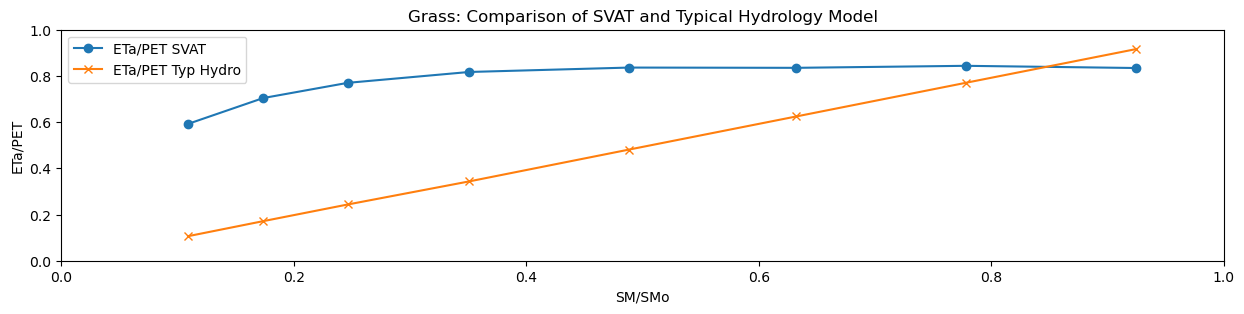

Figure 1: SM/SMo vs ETa/PET for Grass


,lambdaE_SVAT (W m-2),Eta_SVAT (mm),SM,PET (mm),ETa Typ Hydro (mm),ETa/PET SVAT,ETa/PET Typ Hydro,SM/SMo
Day,,,,,,,,
0.000000,167.32,5.86,36.99,7.02,6.43,0.83,0.92,0.92
1.000000,165.94,5.81,31.12,6.88,5.30,0.84,0.77,0.78
2.000000,165.76,5.80,25.28,6.95,4.34,0.84,0.62,0.63
3.000000,160.36,5.61,19.54,6.71,3.23,0.84,0.48,0.49
4.000000,152.19,5.33,14.03,6.52,2.24,0.82,0.34,0.35
5.000000,88.10,3.08,9.85,4.00,0.97,0.77,0.24,0.25
6.000000,77.29,2.71,6.94,3.84,0.66,0.70,0.17,0.17
7.000000,69.96,2.45,4.35,4.13,0.44,0.59,0.11,0.11


In [815]:
#Plot SM/SMo vs ETa/PET on same graph
fig, ax = plt.subplots(figsize=(15, 3))

# Assuming grass_data is sorted by 'SM/SMo' for meaningful line plots
# Line plot for SVAT
ax.plot(grass_data['SM/SMo'], grass_data['ETa/PET SVAT'], label='ETa/PET SVAT', marker='o')

# Line plot for Typical Hydrology
ax.plot(grass_data['SM/SMo'], grass_data['ETa/PET Typ Hydro'], label='ETa/PET Typ Hydro', marker='x')

ax.set_title('Grass: Comparison of SVAT and Typical Hydrology Model')
ax.set_xlabel('SM/SMo')
ax.set_ylabel('ETa/PET')
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.legend()

plt.show()
print("Figure 1: SM/SMo vs ETa/PET for Grass")

display_averages(grass_data, "Grass")




### **a) How the results of ET<sub>a</sub> from a generic hydrologic model (GHM) compares with those from a SVAT scheme for a grassy surface?** 

As shown in Figure 1 above, GHM $\frac{ET_{a}}{PET}$ shows a linear increase with $\frac{SM}{SM_{0}}$ and ranges from 0.11 to 0.92 while the SVAT $\frac{ET_{a}}{PET}$ has a non-liear increase with $\frac{SM}{SM_{0}}$ that levels out at higher SM values, and also shows a smaller range from 0.59 to 0.84. The GHM model calculate ET<sub>a</sub> from PET using the following equation: 

\begin{align*}
\text{Actual Evapotranspiration (FAO REF Crop Method):} & \\
ET_a & = PET \times \left( \frac{SM}{SM_0} \right) \\
& \text{Where:} \\
& ET_a: \text{Actual evapotranspiration} (mm/day). \\
& PET: \text{Reference evapotranspiration} (mm/day). \\
& SM: \text{Soil moisture} (mm). \\
& SM_0: \text{Soil moisture at field capacity} (mm).
\end{align*}


which explains the linear relationship between $\frac{ET_{a}}{PET}$ and $\frac{SM}{SM_{0}}$. The GHM model generally underpredicts ET<sub>a</sub> compared to the SVAT unless the soil is close to saturation, in which case it slightly over predicts ET<sub>a</sub>. 


## **b) What type of implication you can imagine occurring from such differences on hydrologic prediction (water balance, i.e. ET and Streamflow) coming out of both types of models for a grassy surface?**
The divergent predictions of actual evapotranspiration (ET<sub>a</sub>) between GHM and SVAT schemes can significantly impact hydrologic forecasting and management practices: 

#### **Agriculture & Irrigation Management**
- A grassy agricultural field, such as an alfalfa crop or pasture, might rely on either of these models for timing their irrigation. Since the GHM model underpredicts ET<sub>a</sub> compared to SVAT, if the farmer were using the GHM model, they might delay irrigation or apply less water than necessary. Conversely, using the SVAT model, which may predict higher ET<sub>a</sub> rates, could lead to earlier or more frequent irrigation events. This discrepancy can affect crop health, yield, and water use efficiency.

#### **Watershed Management**
- Watershed managers might use these models to predict streamflow from grassy areas into reservoirs. The GHM's tendency to underpredict ET<sub>a</sub> at lower soil moisture levels could lead to overestimations of streamflow, potentially affecting water allocation, reservoir management, and flood prediction.

#### **Ecosystem Services and Climate Change Adaptation**
- The accurate prediction of ET<sub>a</sub> is also vital for understanding ecosystem services provided by grassy surfaces, such as carbon sequestration, temperature regulation, and support of biodiversity. Misestimations of ET<sub>a</sub> can lead to inaccuracies in assessing these services and in developing strategies for adaptation to climate change. For instance, overestimating ET<sub>a</sub> could suggest a higher resilience to drought than actually exists, potentially leading to inadequate preparation for climate variability and extreme events.

## **c) How would you explain the differences you see?**

The ET<sub>a</sub> for SVAT and the PET for the generic hydrologic model (GHM) are calculated using the formula for latent heat flux: 

\begin{align*}
\text{Evapotranspiration Rate Penman-Montith:}\\
\lambda ET & = \frac{\delta \cdot A + \left( \rho_a \cdot c_p \cdot \frac{D_{ref}}{r_a} \right)}{\delta + \gamma \cdot \left( 1 + \frac{r_s}{r_a} \right)} \\
& \text{Where:} \\
& \delta: \text{Slope of the saturation vapor pressure curve} (kPa/^{\circ}C). \\
& A: \text{Available energy, equivalent to net radiation} (W/m^{2}). \\
& \rho_a: \text{Density of air} (kg/m^{3}). \\
& c_p: \text{Specific heat of air at constant pressure} (J/kg/^{\circ}C). \\
& D_{ref}: \text{Vapor pressure deficit at reference level above canopy} (kPa). \\
& r_a: \text{Aerodynamic resistance} (s/m). \\
& \gamma: \text{Psychrometric constant} (kPa/^{\circ}C). \\
& r_s: \text{Surface resistance} (s/m).
\end{align*}

This represents only PET for GHM because we are using parameters from a reference crop, which uses a simplified aerodynamic resistance (r<sub>a</sub>) calculation: 

\begin{align*}
\text{Aerodynamic Resistance Calculation (FAO Ref Crop Method):} & \\
r_a & = \frac{208}{u_m} \\
& \text{Where:} \\
& r_a: \text{Aerodynamic resistance} (s \, m^{-1}). \\
& u_m: \text{Wind speed at measurement height} (m \, s^{-1}). \\
\\
\text{Aerodynamic Resistance Calculation (SVAT):} \\
r_a & = \frac{1}{k^2 \cdot u_m} \cdot \log\left(\frac{z_m - d}{z_0}\right) \cdot \log\left(\frac{z_m - d}{z_0/10}\right) \\
& \text{Where:} \\
& z_m: \text{Measurement height for wind speed} (m). \\
& d: \text{Zero plane displacement height} (m). \\
& z_0: \text{Aerodynamic roughness of crop} (m). \\
& u_m: \text{Wind speed at measurement height} (m/s). \\
& k: \text{von Karman's constant}.
\end{align*}

The FAO equation used for the GHM accounts for the specific aerodynamic roughness or zero plane displacement height of the reference crop, and ignores the potential differences in values for our specific crop. The GHM method also uses a constant value for surface resistance (r<sub>s</sub>), while the SVAT method accounts for how soil heat flux, the vapor pressure deficit, temperature, and soil moisture affect the surface resistance:

\begin{align*}
\text{Resistance to Soil Heat Flux:} & \\
gR & = \frac{SW_{in} \cdot (1000 + KR)}{1000 \cdot (SW_{in} + KR)} \\
& \text{Where:} \\
& SW_{in}: \text{Incoming shortwave radiation} (W m^{-2}). \\
& KR: \text{Environmental constant} (W m^{-2}). \\
\\
\text{Resistance to Vapor Pressure Deficit:} & \\
gD & = 1 + KD_1 \cdot D + KD_2 \cdot D^2 \\
& \text{Where:} \\
& D: \text{Vapor pressure deficit} (kPa). \\
& KD_1, KD_2: \text{Environmental constants}. \\
\\
\text{Resistance to Temperature:} & \\
gT & = \frac{(T - TL) \cdot (TH - T)^{aT}}{(T0 - TL) \cdot (TH - T0)^{aT}} \\
& \text{Where:} \\
& T: \text{Temperature} (K). \\
& TL, T0, TH: \text{Environmental constants} (K). \\
& aT: \text{Temperature stress factor}. \\
\\
\text{Resistance to Soil Moisture Flux:} & \\
gSM & = 1 - KM_1 \cdot e^{KM_2 \cdot (SM - SMo)} \\
& \text{Where:} \\
& SM: \text{Soil moisture} (mm). \\
& SMo: \text{Maximum soil moisture accessible to roots} (mm). \\
& KM_1, KM_2: \text{Crop and environmental constants}. \\
\\
\text{Total Surface Conductance:} & \\
gs & = gR \cdot gD \cdot gT \cdot gSM \cdot g0 \\
& \text{Where:} \\
& g0: \text{Canopy specific constant} (mm s^{-1}). \\
\\
\text{Total Surface Resistance:} & \\
rs & = \frac{1}{gs} \\
& \text{Where:} \\
& gs: \text{Total surface conductance} (mm s^{-1}). \\
\end{align*}


In order to convert the PET for GHM into ET<sub>a</sub>, we apply a a correction that accounts for how close the soil moisture is to the maximum soil moisture holding capacity:

\begin{align*}
\text{Actual Evapotranspiration (FAO REF Crop Method):} & \\
ET_a & = PET \times \left( \frac{SM}{SM_0} \right) \\
& \text{Where:} \\
& ET_a: \text{Actual evapotranspiration} (mm/day). \\
& PET: \text{Reference evapotranspiration} (mm/day). \\
& SM: \text{Soil moisture} (mm). \\
& SM_0: \text{Soil moisture at field capacity} (mm).
\end{align*}

The implication of the differences in ET<sub>a</sub> calculations is that the GHM method relies on soil moisture to represent changes in surface resistance to accurately correct PET into ET<sub>a</sub>, while SVAT dynamically adjusts surface resistance in response to changes in soil heat flux, temperature, VPD, and soil moisture. The GHM method also relies on our crop of interest having a similar aerodynamic roughness and zero plane displacement to the reference crop, while the SVAT method calculates an aerodynamic resistance specific to our crop characteristics. In our model, differences in r<sub>a</sub> and r<sub>s</sub>, which could be due to fluctuations in incoming solar radiation, temperature, VPD, soil moisture, or differences between the reference crop and our crop, explain the differences between the ET<sub>a</sub> of the SVAT and GHM models. 

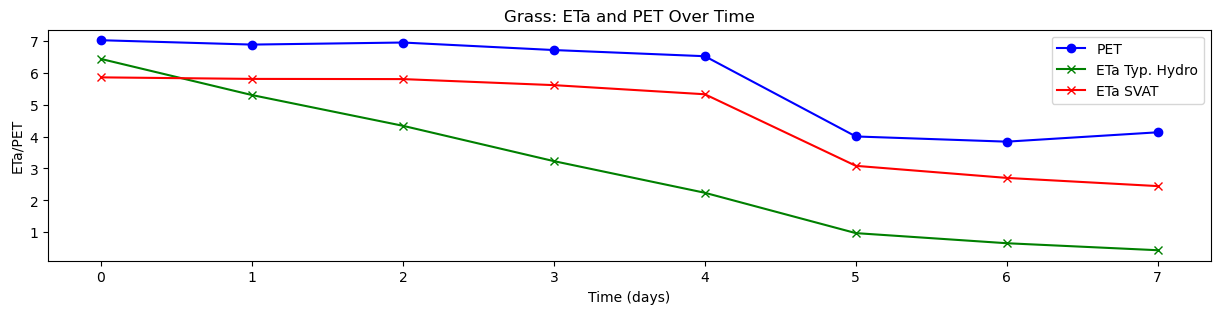

Figure 2: ETa and PET Over Time for Grass


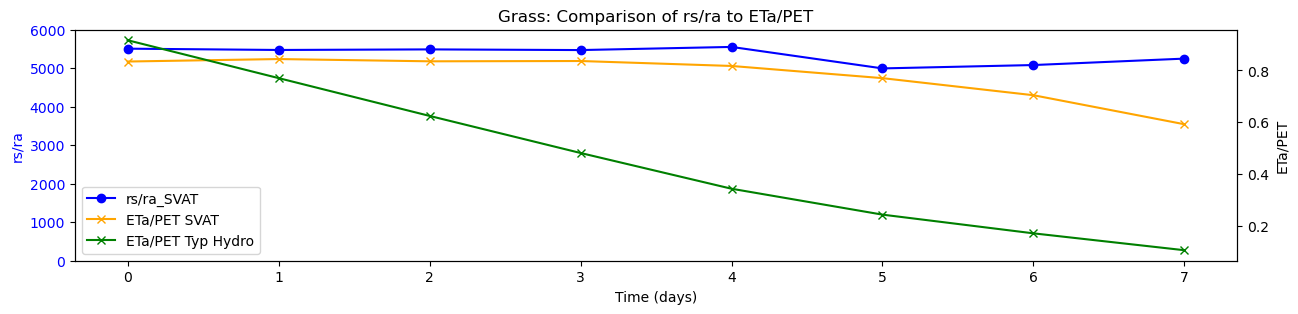

Figure 3: rs/ra and ETa/PET Over Time for Grass.


In [816]:
#Plot ETa and PET on same graph with time on x axis
fig, ax = plt.subplots(figsize=(15, 3))
ax.plot(grass_data['PET (mm)'], label='PET', marker='o', color='blue')
ax.plot(grass_data['ETa Typ Hydro (mm)'], label='ETa Typ. Hydro', marker='x', color='green')
ax.plot(grass_data['Eta_SVAT (mm)'], label='ETa SVAT', marker='x', color='red')
ax.set_title('Grass: ETa and PET Over Time')
ax.set_xlabel('Time (days)')
ax.set_ylabel('ETa/PET')
ax.legend()
plt.show()
print("Figure 2: ETa and PET Over Time for Grass")

#Plot rs and ETA/PET on same graph with time on x axis and rs and ETa/PET each oin their own y axis
fig, ax = plt.subplots(figsize=(15, 3))

# Plotting on the primary y-axis
line1, = ax.plot(grass_data['rs/ra_SVAT'], label='rs/ra_SVAT', marker='o', color='blue')  # Save the line object
ax.set_title('Grass: Comparison of rs/ra to ETa/PET')
ax.set_xlabel('Time (days)')
ax.set_ylabel('rs/ra', color = 'blue')
ax.tick_params(axis='y', labelcolor='blue')
ax.set_ylim(0, 6000)
# Creating a secondary y-axis
ax2 = ax.twinx()
line2, = ax2.plot(grass_data['ETa/PET SVAT'], label='ETa/PET SVAT', marker='x', color='orange')  # Save the line object
line3, = ax2.plot(grass_data['ETa/PET Typ Hydro'], label='ETa/PET Typ Hydro', marker='x', color='green')  # Save the line object
ax2.set_ylabel('ETa/PET')

# Creating a combined legend for both axes
labels = [line1.get_label(), line2.get_label(), line3.get_label()]
lines = [line1, line2, line3]
ax.legend(lines, labels, loc='lower left')  # Single legend for all lines

plt.show()
print("Figure 3: rs/ra and ETa/PET Over Time for Grass.")


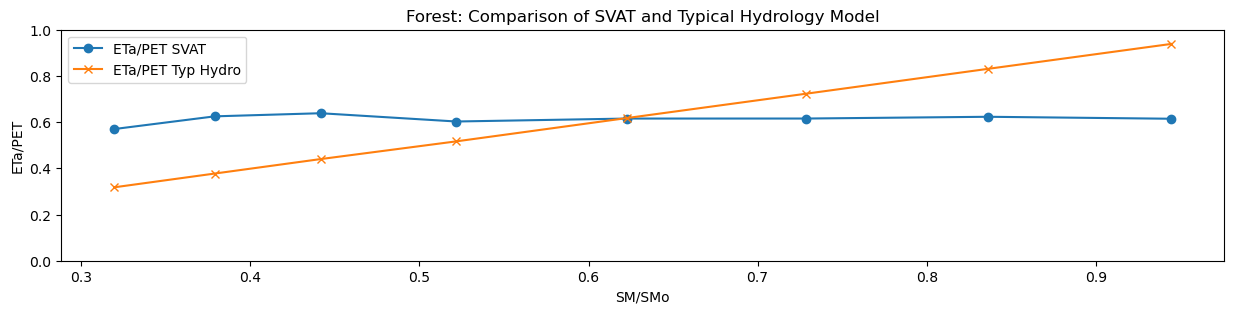

Figure 4: SM/SMo vs ETa/PET for Forest


,lambdaE_SVAT (W m-2),Eta_SVAT (mm),SM,PET (mm),ETa Typ Hydro (mm),ETa/PET SVAT,ETa/PET Typ Hydro,SM/SMo
Day,,,,,,,,
0.000000,123.28,4.31,37.78,7.02,6.59,0.61,0.94,0.94
1.000000,122.55,4.29,33.45,6.88,5.72,0.62,0.83,0.84
2.000000,122.19,4.28,29.14,6.95,5.02,0.62,0.72,0.73
3.000000,118.02,4.13,24.92,6.71,4.15,0.62,0.62,0.62
4.000000,112.25,3.93,20.87,6.52,3.37,0.60,0.52,0.52
5.000000,73.05,2.56,17.66,4.00,1.76,0.64,0.44,0.44
6.000000,68.59,2.40,15.16,3.84,1.45,0.62,0.38,0.38
7.000000,67.34,2.36,12.78,4.13,1.31,0.57,0.32,0.32


In [817]:
#Plot SM/SMo vs ETa/PET 
fig, ax = plt.subplots(figsize=(15, 3))
ax.plot(forest_data['SM/SMo'], forest_data['ETa/PET SVAT'], label='ETa/PET SVAT', marker='o')
ax.plot(forest_data['SM/SMo'], forest_data['ETa/PET Typ Hydro'], label='ETa/PET Typ Hydro', marker='x')
ax.set_title('Forest: Comparison of SVAT and Typical Hydrology Model')
ax.set_xlabel('SM/SMo')
ax.set_ylabel('ETa/PET')
ax.set_ylim(0, 1)
ax.legend()
plt.show()
print("Figure 4: SM/SMo vs ETa/PET for Forest")

display_averages(forest_data, "Forest")


### **a) How the results of ET<sub>a</sub> from a generic hydrologic model (GHM) compares with those from a SVAT scheme for a forested surface?** 

The SVAT model for a forested surface results in an $\frac{ET_{a}}{PET}$ that is relatively constant across all values of SM, with a minimum value of 0.57 and a max of 0.64. on the other hand, the GHM model shows a linear relationship with $\frac{SM}{SM_{0}}$ and has a wider range of 0.32 to 0.98. Figure 6 below shows how the SVAT $\frac{ET_{a}}{PET}$ responds to changes in the SVAT calculated $\frac{r_{s}}{r_{a}}$, while the GHM $\frac{ET_{a}}{PET}$ show little correlation with the SVAT calculated $\frac{r_{s}}{r_{a}}$. The GHM model under predicts ET<sub>a</sub> compared to the SVAT model at low SM values, and over predicts ET<sub>a</sub> compared to SVAT at high SM values. 

Figure 7 below shows a complete dependence of ET<sub>a</sub> on $\frac{SM}{SM_{0}}$ for the GHM model, while the SVAT model depends on a wider array of variables.

### **b) What type of implication you can imagine occurring from such differences on hydrologic prediction (water balance, i.e. ET and Streamflow) coming out of both types of models for a forested surface?**

The discrepancies in actual evapotranspiration (ET<sub>a</sub>) predictions between the GHM and SVAT models have distinct implications for hydrologic predictions concerning water balance and streamflow, particularly in forested areas. Forest ecosystems present unique challenges and considerations, including deep rooting systems, variable canopy storage, and complex interactions with the atmosphere:

#### **Forest Health and Productivity**: 
- Accurate predictions of ET<sub>a</sub> are critical for understanding water availability within forest ecosystems, which in turn affects tree health, growth rates, and overall forest productivity. The GHM model, which might underpredict ET<sub>a</sub> at lower soil moisture levels, could lead to an underestimation of water stress on trees, potentially affecting decisions related to forest management and conservation.

#### **Streamflow and Reservoir Management**: 
- Forests play a crucial role in regulating streamflow and maintaining water quality. Over- or underestimations of ET<sub>a</sub> can affect predictions of streamflow volume and timing, impacting reservoir management, flood control, and water supply planning. The SVAT model, with its detailed representation of soil-vegetation-atmosphere interactions, might provide more accurate streamflow predictions in forested catchments.

#### **Vulnerability to Drought and Fire Risk**: 
- The ability to accurately predict ET<sub>a</sub> is important in assessing forest vulnerability to drought and fire. Models that underpredict ET<sub>a</sub> might underestimate drought stress and fire risk, potentially compromising preparedness and response strategies.


### **c) How would you explain the differences you see?**

In addition to the general explaination provided in part 1c above, the differences between the SVAT and GHM models for forested areas are exacerbated by the basis of the GHM model parameters on a grassy surface. There are signigicant differences in aerodynamic and surface resistance forest and grass due to differences in surface roughness, zero plane displacement height, incident solar radation & soil heat flux, soil moisture flux, and temperature differences. These differences are generally ignored in favor of a grass reference crop in the GHM model, but accounted for in the SVAt model, which results in two estimates of ET<sub>a</sub> that weakly, if at all, correlated.

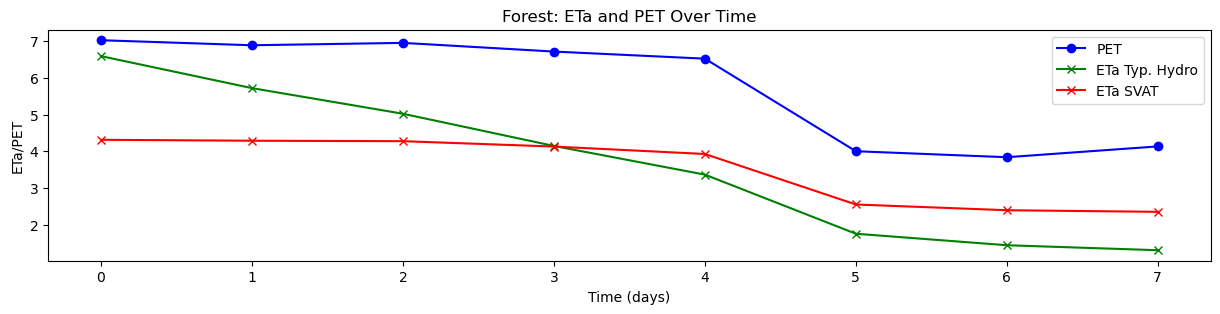

Figure 5: ETa and PET Over Time for Forest


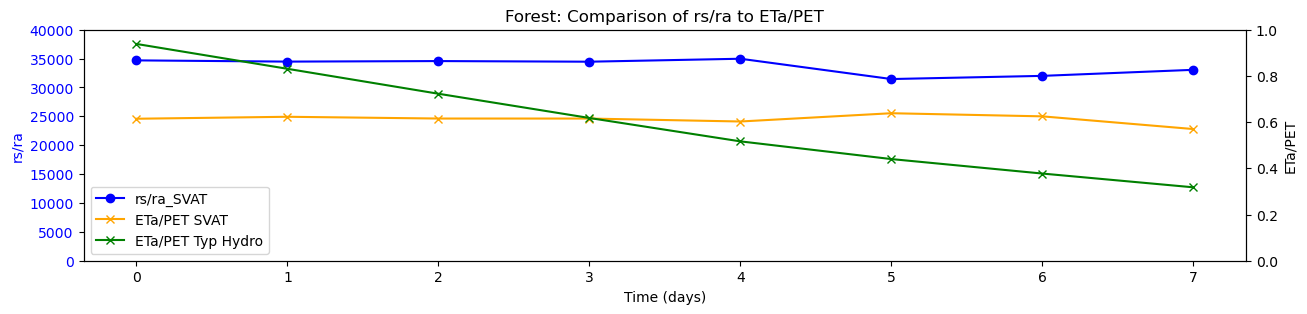

Figure 6: rs/ra and ETa/PET Over Time for Forest.


In [818]:
#Plot ETa and PET on same graph with time on x axis
fig, ax = plt.subplots(figsize=(15, 3))
ax.plot(forest_data['PET (mm)'], label='PET', marker='o', color='blue')
ax.plot(forest_data['ETa Typ Hydro (mm)'], label='ETa Typ. Hydro', marker='x', color='green')
ax.plot(forest_data['Eta_SVAT (mm)'], label='ETa SVAT', marker='x', color='red')
ax.set_title('Forest: ETa and PET Over Time')
ax.set_xlabel('Time (days)')
ax.set_ylabel('ETa/PET')
ax.legend()
plt.show()
print("Figure 5: ETa and PET Over Time for Forest")


#Plot rs and ETA/PET on same graph with time on x axis and rs and ETa/PET each oin their own y axis
fig, ax = plt.subplots(figsize=(15, 3))

# Plotting on the primary y-axis
line1, = ax.plot(forest_data['rs/ra_SVAT'], label='rs/ra_SVAT', marker='o', color='blue')  # Save the line object
ax.set_title('Forest: Comparison of rs/ra to ETa/PET')
ax.set_xlabel('Time (days)')
ax.set_ylabel('rs/ra', color = 'blue')
ax.tick_params(axis='y', labelcolor='blue')
#Set yaxis limits to 0 to 40000
ax.set_ylim(0, 40000)

# Creating a secondary y-axis
ax2 = ax.twinx()
line2, = ax2.plot(forest_data['ETa/PET SVAT'], label='ETa/PET SVAT', marker='x', color='orange')  # Save the line object
line3, = ax2.plot(forest_data['ETa/PET Typ Hydro'], label='ETa/PET Typ Hydro', marker='x', color='green')  # Save the line object
ax2.set_ylabel('ETa/PET')
ax2.set_ylim(0, 1)

# Creating a combined legend for both axes
labels = [line1.get_label(), line2.get_label(), line3.get_label()]
lines = [line1, line2, line3]
ax.legend(lines, labels, loc='lower left')  # Single legend for all lines

plt.show()
print("Figure 6: rs/ra and ETa/PET Over Time for Forest.")

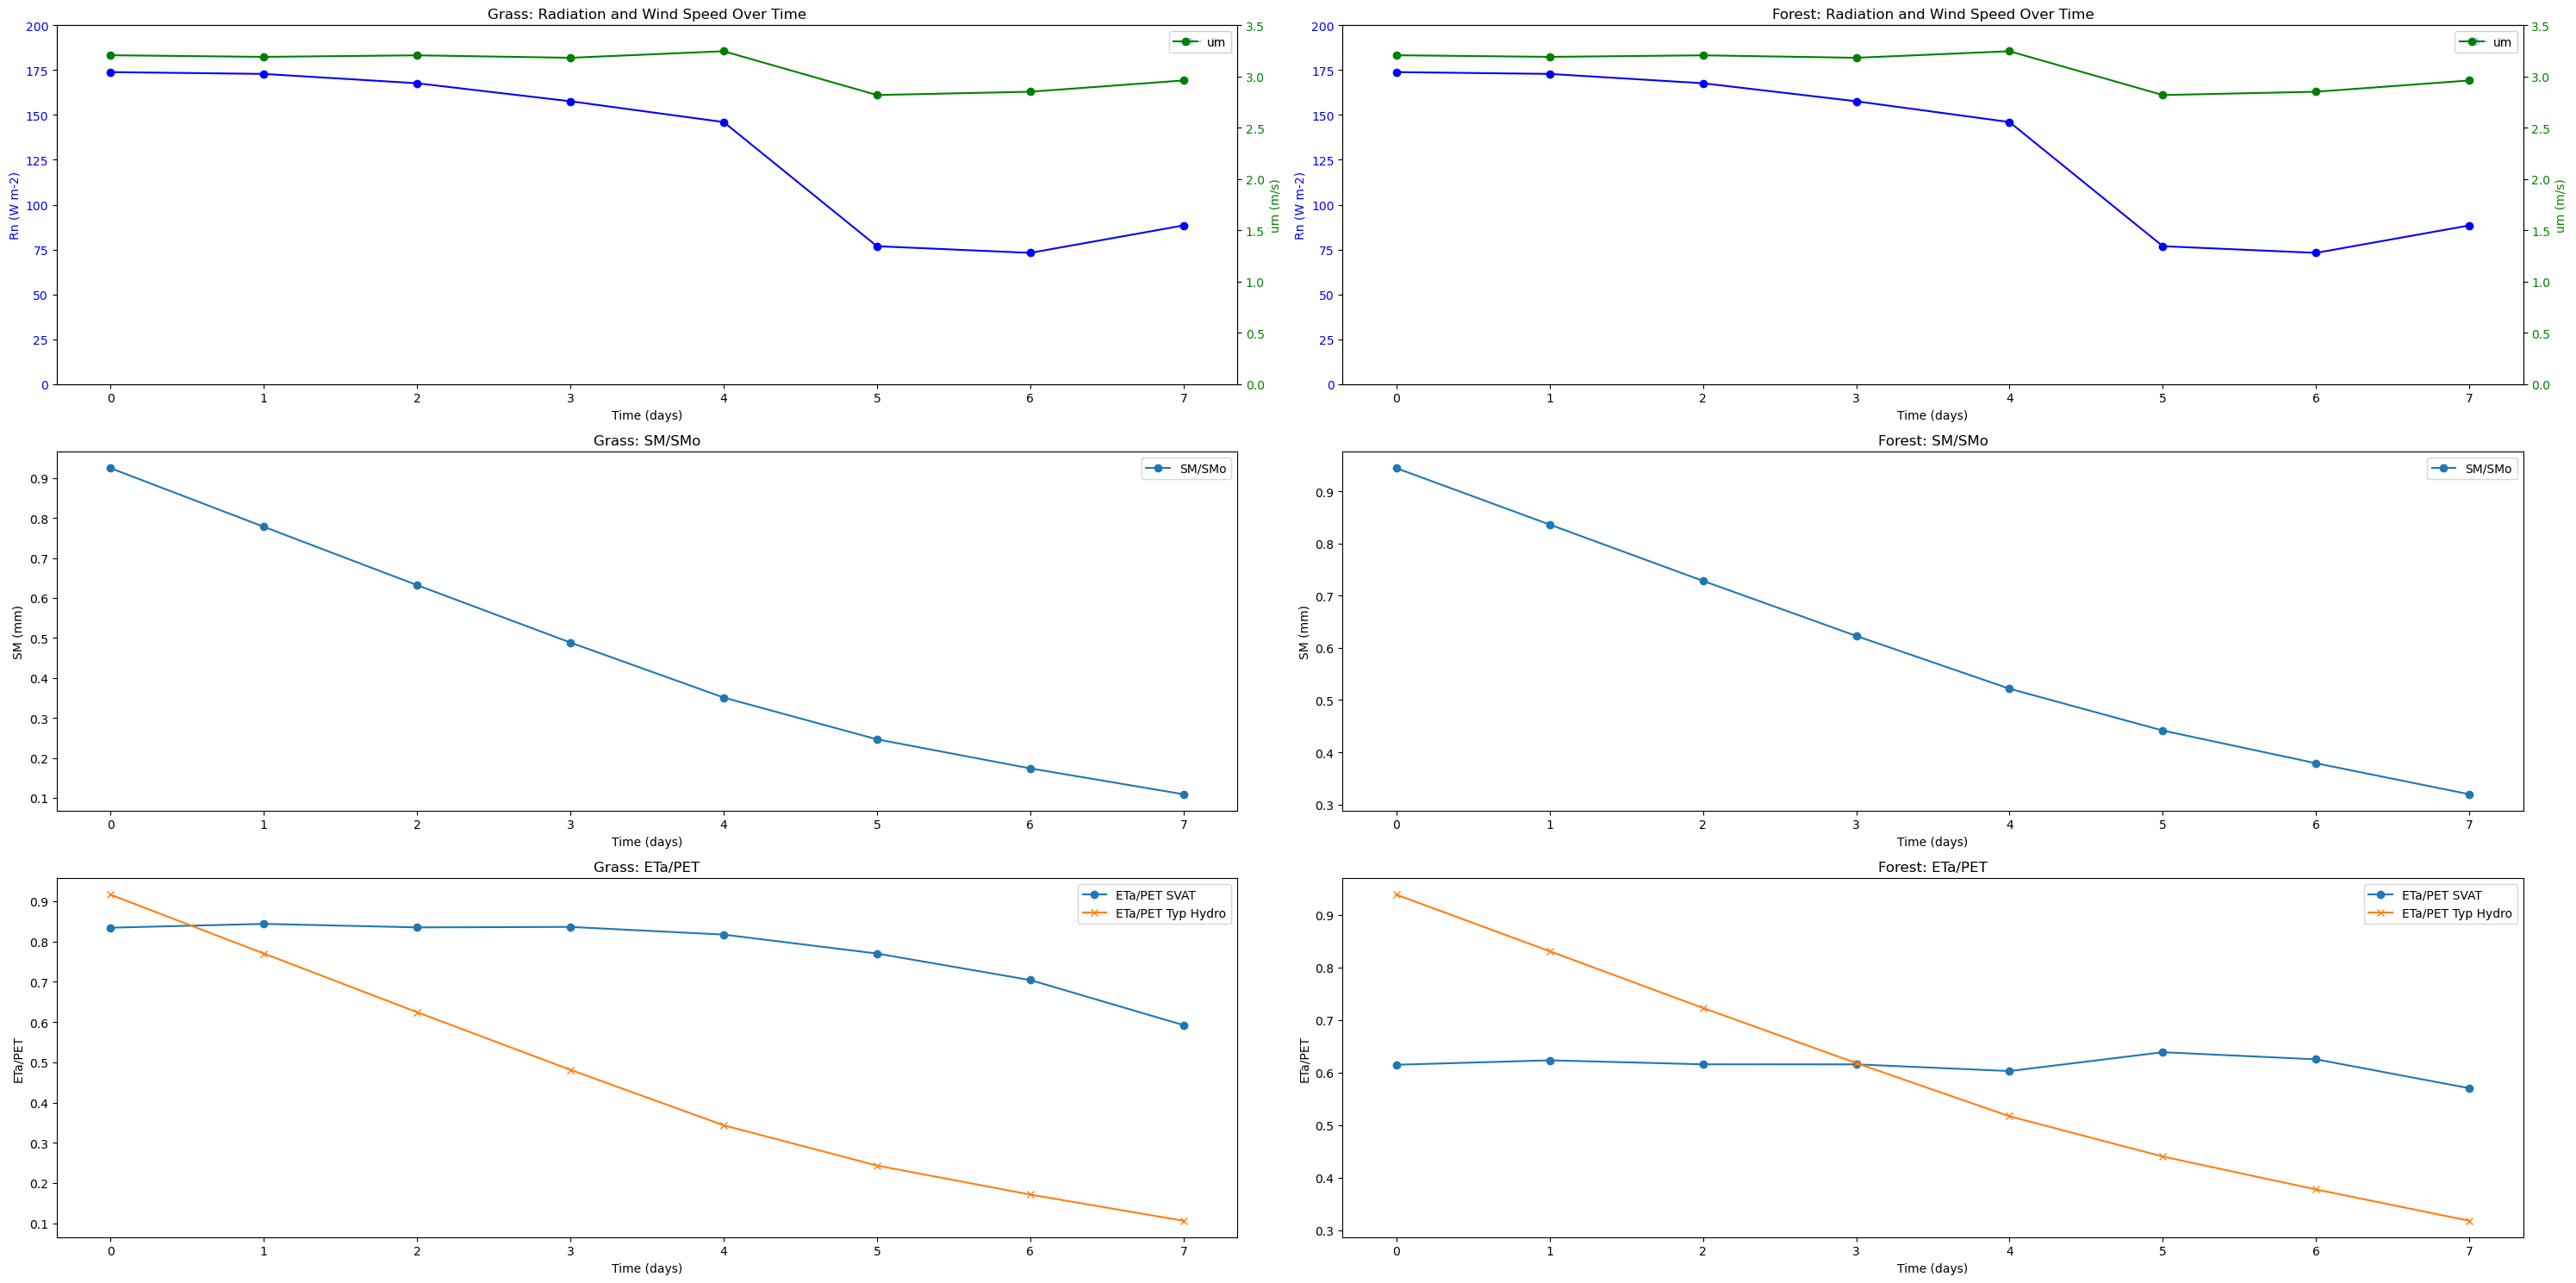

Figure 7: Comparing SVAT and GHM for grass and forest against radiation, wind speed, and soil mositure over time


In [819]:
#================= Radiation and Wind Speed Over Time =================

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(30, 15))  # Adjust figsize as needed


#Plot Forest and IWnd Speed on Same graph for grass and forest
axs[0, 0].plot(grass_data['Rn'], label='Rn', marker='o', color='blue')
axs[0, 0].set_title('Grass: Radiation and Wind Speed Over Time')
axs[0, 0].set_xlabel('Time (days)')
axs[0, 0].set_ylabel('Rn (W m-2)', color='blue')
axs[0, 0].set_ylim(0, 200)
axs[0, 0].tick_params(axis='y', labelcolor='blue')
axs[0, 0].legend()

ax2 = axs[0, 0].twinx()
ax2.plot(grass_data['um'], label='um', marker='o', color='green')
ax2.set_ylabel('um (m/s)', color='green')
ax2.set_ylim(0, 3.5)
ax2.tick_params(axis='y', labelcolor='green')
ax2.legend()

#Plot Forest and IWnd Speed on Same graph for grass and forest
axs[0, 1].plot(forest_data['Rn'], label='Rn', marker='o', color='blue')
axs[0, 1].set_title('Forest: Radiation and Wind Speed Over Time')
axs[0, 1].set_xlabel('Time (days)')
axs[0, 1].set_ylabel('Rn (W m-2)', color='blue')
axs[0, 1].set_ylim(0, 200)
axs[0, 1].tick_params(axis='y', labelcolor='blue')
axs[0, 1].legend()

ax2 = axs[0, 1].twinx()
ax2.plot(forest_data['um'], label='um', marker='o', color='green')
ax2.set_ylabel('um (m/s)', color='green')
ax2.set_ylim(0, 3.5)
ax2.tick_params(axis='y', labelcolor='green')
ax2.legend()

# Top left - SM Grass
axs[1, 0].plot(grass_data['SM/SMo'], label='SM/SMo', marker='o')
axs[1, 0].set_title('Grass: SM/SMo')
axs[1, 0].set_xlabel('Time (days)')
axs[1, 0].set_ylabel('SM (mm)')
axs[1, 0].legend()

# Top right - SM Forest
axs[1, 1].plot(forest_data['SM/SMo'], label='SM/SMo', marker='o')
axs[1, 1].set_title('Forest: SM/SMo')
axs[1, 1].set_xlabel('Time (days)')
axs[1, 1].set_ylabel('SM (mm)')
axs[1, 1].legend()

# Bottom left - ETa/PET Grass
axs[2, 0].plot(grass_data['ETa/PET SVAT'], label='ETa/PET SVAT', marker='o')
axs[2, 0].plot(grass_data['ETa/PET Typ Hydro'], label='ETa/PET Typ Hydro', marker='x')
axs[2, 0].set_title('Grass: ETa/PET')
axs[2, 0].set_xlabel('Time (days)')
axs[2, 0].set_ylabel('ETa/PET')
axs[2, 0].legend()

# Bottom right - ETa/PET Forest
axs[2, 1].plot(forest_data['ETa/PET SVAT'], label='ETa/PET SVAT', marker='o')
axs[2, 1].plot(forest_data['ETa/PET Typ Hydro'], label='ETa/PET Typ Hydro', marker='x')
axs[2, 1].set_title('Forest: ETa/PET')
axs[2, 1].set_xlabel('Time (days)')
axs[2, 1].set_ylabel('ETa/PET')
axs[2, 1].legend()

plt.tight_layout()  # Adjust layout to make sure everything fits without overlapping
plt.show()
print("Figure 7: Comparing SVAT and GHM for grass and forest against radiation, wind speed, and soil mositure over time")